In [1]:
import numpy as np
import sklearn
import pandas as pd
import seaborn as sns
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import time
from scipy import signal
from sklearn.preprocessing import MinMaxScaler
from preproc import *
import skimage.io
from IPython import display

import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from torchvision import transforms
import torchvision
import os
from tqdm import tqdm


import matplotlib.pyplot as plt
import numpy as np
import skimage
from skimage import io,transform
%matplotlib inline


import warnings
warnings.filterwarnings('ignore')

# import random
# random.seed(9001)
# plt.figsize['']
plt.rcParams["figure.figsize"] = (10,5)

In [2]:
inspector = get_df(pd.read_csv('../../magnetogram.csv'))
anomalies = pd.read_csv('../../anomalies.csv',decimal=',')
welds = pd.read_csv('../../sections.csv',decimal=',')

In [3]:
inspector.head(3)

,1.1,1.2,1.3,1.4,2.1,2.2,2.3,2.4,3.1,3.2,...,14.3,14.4,15.1,15.2,15.3,15.4,16.1,16.2,16.3,16.4
7.67144,3171,3180,3174,3164,3172,3178,3188,3199,0,0,...,3200,3193,3207,3195,3195,3173,3187,3189,3206,3183
7.67484,3172,3180,3177,3166,3170,3179,3189,3200,0,0,...,3200,3194,3206,3195,3196,3173,3186,3188,3202,3183
7.67819,3171,3176,3177,3165,3172,3176,3190,3199,0,0,...,3200,3189,3206,3194,3198,3175,3186,3191,3201,3182


In [4]:
pipe_defects = []
welf_defects = []
for i in range(len(anomalies)):
    if 'шов' not in anomalies['Местоположение дефекта'].values[i].lower():
        pipe_defects.append(anomalies['Дистанция, м'].values[i])
    else:
        welf_defects.append(anomalies['Дистанция, м'].values[i])       
pipe_defects = np.array(pipe_defects)
welf_defects = np.array(welf_defects)
print("Number of pipe defects:",len(pipe_defects))
print("Number of welds defects:",len(welf_defects))


Number of pipe defects: 711
Number of welds defects: 34


In [5]:
print('total length of dataset',len(inspector))
print('total length of pipeline',inspector.index[-1] - inspector.index[0],'meters')

total length of dataset 4477644
total length of pipeline 15140.12259 meters


In [6]:
welds_locat = welds['Местоположение начала секции по дистанции трубопровода, м'].values

def plot_ins(x1,x2):
    inspector.loc[x1:x2].plot()
    for weld in welds_locat[(welds_locat <= x2) & (welds_locat >= x1)]:
        plt.axvline(weld,color='black')
    plt.legend().remove()
    plt.show()
    
def plot_defects(index_deffect,width=0.2):
    f = plt.figure(figsize=(16,6))
    ax1 = f.add_subplot(121)
    ax2 = f.add_subplot(122)

    x1 = index_deffect-width
    x2 = index_deffect+width
    
    ax2.plot(inspector.loc[x1:x2])
    for weld in welds_locat[(welds_locat <= x2) & (welds_locat >= x1)]:
        ax2.axvline(weld,color='black')
        
    ax1.imshow(inspector.loc[x1:x2].values.T)
    
    plt.show()


In [7]:
# for defect in range(len(pipe_defects)):
#     image = inspector.loc[pipe_defects[defect]:pipe_defects[defect]+0.4].T
#     image[image==0.0]=np.nan
#     image = image.values
#     image = image[:,:64]
    
#     # image = image.astype(np.uint8)
#     skimage.io.imsave('./pics/init/{}.png'.format(defect),image)
#     image = skimage.io.imread('./pics/init/{}.png'.format(defect))
#     image[image==255]=254    
#     skimage.io.imsave('./pics/init/{}.png'.format(defect),image)


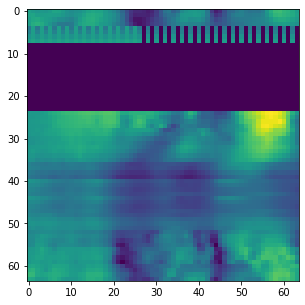

In [8]:
mask = skimage.io.imread('./pics/mask/val/676.png')[:,:,0]
plt.imshow(mask)

In [9]:
### Let's make a UNet with 5 levels and 64, 128, 256, 256, 256 channels
### (n_base_channels=64)
class Unet(nn.Module):
    def __init__(self, n_base_channels=32):
        super().__init__()
        
        # your code here
        self.down_blocks = nn.ModuleList([
            UnetDownBlock(1, n_base_channels),
            UnetDownBlock(n_base_channels, n_base_channels * 2),
            UnetDownBlock(n_base_channels * 2, n_base_channels * 4),
            UnetDownBlock(n_base_channels * 4, n_base_channels * 4)
        ])
        self.up_blocks = nn.ModuleList([
            UnetUpBlock(n_base_channels * 4, n_base_channels * 2),
            UnetUpBlock(n_base_channels * 2, n_base_channels * 1),
            UnetUpBlock(n_base_channels * 1, n_base_channels * 1),
        ])
        self.final_block = nn.Sequential(
            #  nn.Conv2d(n_base_channels, 3, kernel_size=1, padding=0),
            nn.Conv2d(n_base_channels, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
            # nn.Softmax()
        )
            
        
    def forward(self, x):
        out = x
        outputs_before_pooling = []
        for i, block in enumerate(self.down_blocks):
            out, before_pooling = block(out)
            outputs_before_pooling.append(before_pooling)
        out = before_pooling
        
        for i, block in enumerate(self.up_blocks):    # NB: it's easier to understand when using counter (i=3, etc.)
            out = block(out, outputs_before_pooling[-i - 2])
        out = self.final_block(out)
        
        return out

class UnetDownBlock(nn.Module):
    """
    # UNetDownBlock: Conv + ReLU + Conv + ReLU + MaxPool
    """
    def __init__(self, in_channels, out_channels, pooling=True):
        super().__init__()
        
        # your code here
        self.convs = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
    def forward(self, x):
        # x: a tensor of shape (batch_size, in_channels, layer_height, layer_width)
        out_before_pooling = self.convs(x)
        out = self.maxpool(out_before_pooling)

        return out, out_before_pooling
    


class UnetUpBlock(nn.Module):
    """
    UNetUpBlock: upsampling + concat + Conv + ReLU
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.upsample = nn.Upsample(scale_factor=2)
        self.convs = nn.Sequential(
            nn.Conv2d(in_channels * 2, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        
    def forward(self, x, x_bridge):
        # x: a tensor of shape (batch_size, in_channels, layer_height // 2, layer_width // 2)
        # x_bridge: a tensor of shape (batch_size, in_channels, layer_height, layer_width)
        
        # your code here
        x_up = self.upsample(x)
        x_concat = torch.cat([x_up, x_bridge], dim=1)
        out = self.convs(x_concat)
        
        return out
    


In [10]:
### Target metric ###
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union

In [11]:
# Augmentation. I do not invent the wheel, citing from https://pastebin.com/BunFVpTE.I agree with the implementation, and also developed and added a useful method.
def RandomExecution(prob):
    def _random_execution(function):
        def wrapped(*args, **kwargs):
            if np.random.random() <= prob:
                return function(*args, **kwargs)
            else:
                return args[1:]
        return wrapped
    return _random_execution
 
class HorizontalFlip():
    @RandomExecution(0.3)
    def __call__(self, image, mask):
        return np.flip(image, 1), np.flip(mask, 1)
 
class VerticalFlip():
    @RandomExecution(0.3)
    def __call__(self, image, mask):
        return np.flip(image, 0), np.flip(mask, 0)
 
class Rotate():
    def __init__(self, angle):
        self._angle = angle
 
    @RandomExecution(0.3)
    def __call__(self, image, mask):
        _angle = np.random.uniform(-self._angle, self._angle)
        image = transform.rotate(image, _angle)
        mask  = transform.rotate(mask, _angle)
        mask[:,:,0] = 1. - mask[:,:,1]
        return image, mask
  
class Aurmentation():
    def __init__(self, prob, angle):
        self._prob = prob
        self.modifications = [HorizontalFlip(),
                              VerticalFlip(),
#                               Rotate(angle),
                             ]
 
    def __call__(self, x_batch, y_batch):
        batch_idx = x_batch.shape[0]
       
        for idx in range(batch_idx):
            for _modificator in self.modifications:
                x_batch[idx], y_batch[idx] = _modificator(x_batch[idx], y_batch[idx])
        return x_batch, y_batch
   
   
class EmptyAurmentation():
    def __init__(self):
        pass
    def __call__(self, x_batch, y_batch):
        return x_batch, y_batch
   
class Reader():
    DATA_FOLDER = 'pics'
    MASK_FOLDER = 'done'
#     MASK_POSTFIX = '-cells.png'
   
    def  __init__(self,subfolder, augmentation=EmptyAurmentation(), mask=True, batch_size=8):
        self.mask = mask
        self.batch_size = batch_size
 
        self.data_folder = os.path.join('pics/init', subfolder)  #os.path.join(self.DATA_FOLDER, subfolder)
        self.mask_folder = os.path.join('pics/mask', subfolder) #os.path.join(self.MASK_FOLDER, subfolder) if mask else False
       
        self.data = {}
        for el in os.listdir(self.data_folder):
            _data = os.path.join(self.data_folder, el)
            if mask:
                #_mask_path = el.split('-actin')[0] + self.MASK_POSTFIX
#                 _mask_path = os.path.join(self.mask_folder, _mask_path)
                _mask_path = os.path.join(self.mask_folder, el)
                self.data[_data] = _mask_path
            else:
                self.data[_data] = el
 
        self.augmentation = augmentation
       
 
    def read_batch_X(self, data, DIVISOR=255.):
        images = [np.expand_dims(io.imread(_name), 0) / DIVISOR for _name in data]
        return np.concatenate(images, axis=0)
   
    def read_batch_Y(self, data, DIVISOR=255.):
        if self.mask:
#             for _name in data:
#                     print(_name)
#                     io.imread(_name)[:,:,0]
#             print(io.imread(data[0]).shape)
            images = [self.modify_image_Y(np.expand_dims(io.imread(_name)[:,:,0], 0) / DIVISOR) for _name in data]
            return np.concatenate(images, axis=0)
        else:
            return data
   
    def modify_image_Y(self, image):#, edge=0.5):
#         cells = (image[:,:] >= edge).astype(np.float)
#         image = np.concatenate([np.expand_dims(1. - cells, -1), np.expand_dims(cells, -1)], axis=-1)
        cells = (image[:,:] == 1).astype(np.float)
        image = np.concatenate([np.expand_dims(1. - cells, -1), np.expand_dims(cells, -1)], axis=-1)
        return image[:,:,:,1]
 
    def get_batches(self, seed=None, test=True,return_names=False):
        batch_size = self.batch_size
        X, Y = map(np.array, zip(*list(self.data.items())))
        n_samples = len(X)
 
        # Shuffle at the start of epoch
        indices = np.arange(n_samples)
 
        np.random.seed(seed)
        np.random.shuffle(indices)
                
                
        for start in range(0, n_samples, batch_size):
            end = min(start + batch_size, n_samples)
            batch_idx = indices[start:end]
            if test:
                if return_names:
                  yield self.read_batch_X(X[batch_idx]), self.read_batch_Y(Y[batch_idx]), list(self.data.values())
                else:
                  yield self.read_batch_X(X[batch_idx]), self.read_batch_Y(Y[batch_idx])
            else:
                yield self.augmentation(self.read_batch_X(X[batch_idx]), self.read_batch_Y(Y[batch_idx]))

    def get_data(self,batch_size=None):
        X, Y = map(np.array, zip(*list(self.data.items())))
        n_samples = len(X) 
        indices = np.arange(n_samples)
        if batch_size is None:
          yield self.read_batch_X(X[indices]), self.read_batch_Y(Y[indices])
        else:
          for start in range(0, n_samples, batch_size):
            end = min(start + batch_size, n_samples)
            batch_idx = indices[start:end]
            yield self.read_batch_X(X[batch_idx]), self.read_batch_Y(Y[batch_idx])



(2, 64, 64) (2, 64, 64)


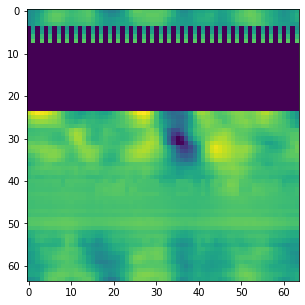

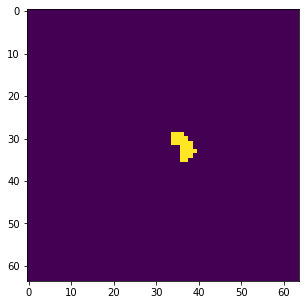

In [12]:
for data in Reader('val', mask=True, batch_size=2, augmentation=Aurmentation(0.5, np.random.randint(30,120) )).get_batches(test=False):
    print(data[0].shape,data[0].shape)
    plt.imshow(data[0][0])
    plt.show()
    plt.imshow(data[1][0])
    break

In [13]:
# It's from here https://discuss.pytorch.org/t/solved-class-weighed-binary-crossentropy-not-working-even-with-equal-weights/47055 with a little adaptation.
def weighted_binary_cross_entropy(output, target, class_weights=None):        
    if class_weights is not None:
        assert len(class_weights) == 2       
        loss = class_weights[1] * (target * torch.log(output)) + \
               class_weights[0] * ((1 - target) * torch.log(1 - output))
    else:
        loss = target * torch.log(output) + (1 - target) * torch.log(1 - output)
    return torch.neg(torch.mean(loss))

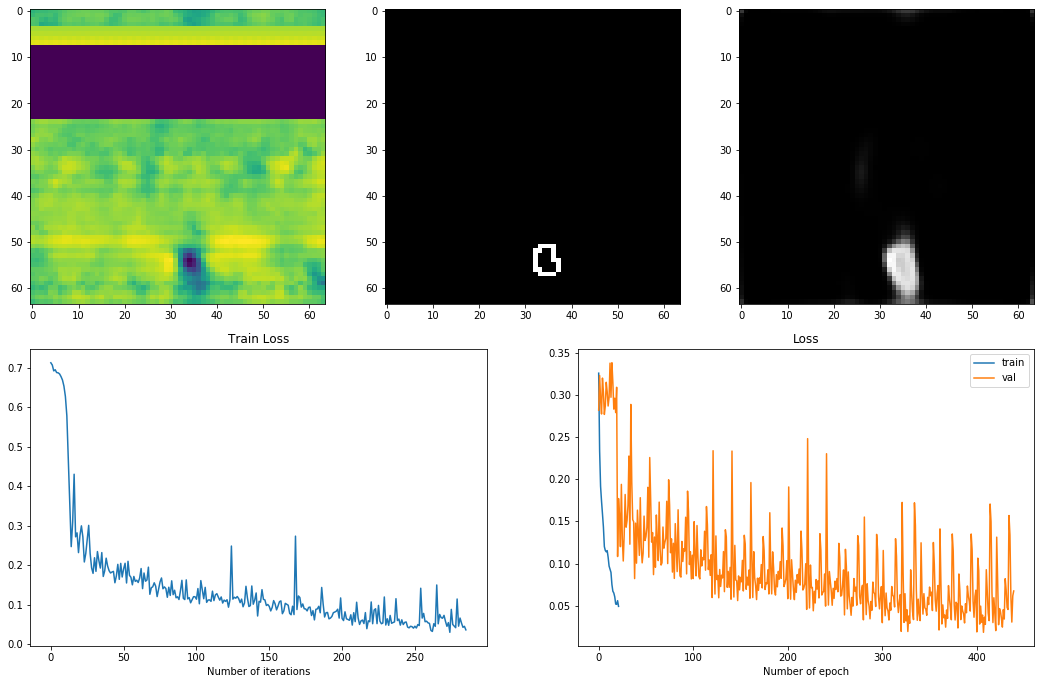

In [19]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = Unet().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.0004)
criterion = weighted_binary_cross_entropy
weights = torch.tensor([1,7]).to(device)
batch_size=4

n_epochs = 22
losses=[]
losses_train=[]
losses_val=[]
for epoch in range(n_epochs):
    model.train()
    n_iters = 0
    for n_iter, data in tqdm(enumerate(Reader('train',mask=True, batch_size=batch_size, augmentation=Aurmentation(0.5, np.random.randint(30,120) )).get_batches(test=False))):
        # images, labels = data[0].to(device), data[1].to(device)
        images, labels = data[0], data[1]
        images = torch.from_numpy(images).unsqueeze(1).to(device).type(torch.float)
        map_true = torch.from_numpy(labels).unsqueeze(1).to(device).type(torch.float)
        map_pred = model(images)
        
#         plt.imshow(map_pred[0,0].detach().numpy())
#         plt.show()

        opt.zero_grad()
        
        loss = criterion(map_pred,map_true,weights)
        losses.append(loss.item())
        loss.backward()
        opt.step()

    losses_train_local=[]
    for data in Reader('train').get_data(batch_size=batch_size):
        imag = torch.from_numpy(data[0]).unsqueeze(1).to(device).type(torch.float)
        true = torch.from_numpy(data[1]).unsqueeze(1).to(device).type(torch.float)    
        opt.zero_grad()
        pred = model(imag)
        loss = criterion(pred,true,weights)
        losses_train_local.append(loss.item())
        del imag,true,pred,loss
    losses_train.append(np.mean(losses_train_local))

    for data in Reader('val').get_data(batch_size=batch_size):
        imag = torch.from_numpy(data[0]).unsqueeze(1).to(device).type(torch.float)
        true = torch.from_numpy(data[1]).unsqueeze(1).to(device).type(torch.float)      
        opt.zero_grad()
        pred = model(imag)
        loss = criterion(pred,true,weights)
        losses_val.append(loss.item())
        del imag,true,pred,loss
     

    display.clear_output(wait=True)
    f = plt.figure(figsize=(18,18))
    plt.subplots_adjust(wspace=0.2, hspace=1.3)
    ax4 = f.add_subplot(223)
    ax4.plot(losses)
    ax4.set_title('Train Loss')
    ax4.set_xlabel('Number of iterations')

    ax5 = f.add_subplot(224)
    ax5.plot(losses_train,label='train')
    ax5.plot(losses_val,label='val')
    ax5.set_title('Loss')
    ax5.legend()
    ax5.set_xlabel('Number of epoch')

    ax1 = f.add_subplot(131)

    ax1.imshow(images[0][0].cpu())

    ax2 = f.add_subplot(132)
    ax2.imshow(map_true[0][0].cpu(),'gray')

    ax3 = f.add_subplot(133)
    ax3.imshow(map_pred[0][0].detach().cpu(),'gray')
    plt.show()


With thereshold 0.0 IoU is 0.0 on validation set


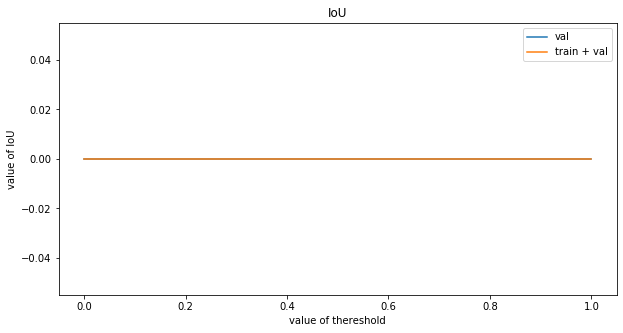

In [15]:
Train_pred = []
Train_true = []
for data in Reader('train').get_data(batch_size=batch_size):
    imag = torch.from_numpy(data[0]).unsqueeze(1).to(device).type(torch.float)
    Train_true.append(torch.from_numpy(data[1]).unsqueeze(1).numpy()[:,0,:,:])
    opt.zero_grad()
    Train_pred.append(model(imag).cpu().data.numpy()[:,0,:,:])
Train_pred = np.concatenate([i for i in Train_pred],axis=0)
Train_true = np.concatenate([i for i in Train_true],axis=0)

Val_pred = []
Val_true = []
for data in Reader('val').get_data(batch_size=batch_size):
    imag = torch.from_numpy(data[0]).unsqueeze(1).to(device).type(torch.float)
    Val_true.append(torch.from_numpy(data[1]).unsqueeze(1).numpy()[:,0,:,:])
    opt.zero_grad()
    Val_pred.append(model(imag).cpu().data.numpy()[:,0,:,:])
Val_pred = np.concatenate(Val_pred,axis=0)
Val_true = np.concatenate(Val_true,axis=0)


val=[]
train_and_val=[]
for thereshold in np.linspace(0,1,101):
  val.append(calc_iou(Val_pred>thereshold,Val_true))
  train_and_val.append(calc_iou(np.concatenate([Train_pred,Val_pred],axis=0) >thereshold,np.concatenate([Train_true,Val_true],axis=0)))
plt.plot(np.linspace(0,1,101),val,label='val')  
plt.plot(np.linspace(0,1,101),train_and_val,label='train + val')
plt.xlabel('value of thereshold')
plt.ylabel('value of IoU')
plt.legend()
plt.title('IoU')  
thereshold = np.array(np.linspace(0,1,101))[np.argmax(val)]
print('With thereshold', thereshold, 'IoU is', max(val) ,'on validation set')

In [16]:
Test_pred = []
Images = []
Names= []
### !!!!!!! TEST !!!!!!! not val
for data in Reader('val', mask=False, batch_size=batch_size, augmentation=EmptyAurmentation()).get_batches(test=True,return_names=True):
    imag = torch.from_numpy(data[0]).unsqueeze(1).to(device).type(torch.float)
    for name in data[2]:
        Names.append(name)
    Images.append(data[0])
    opt.zero_grad()
    pred = model(imag).detach().cpu().squeeze(1).numpy()
#     plt.imshow(pred[0] > thereshold)
    Test_pred.append( (pred >thereshold).astype(float)) 
Test_pred = np.concatenate([i for i in Test_pred],axis=0)
Images = np.concatenate([i for i in Images],axis=0)

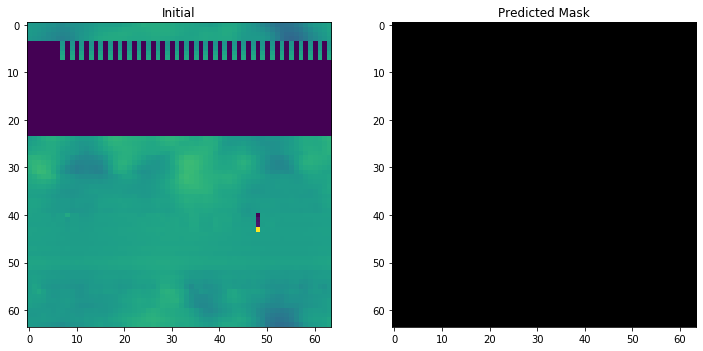

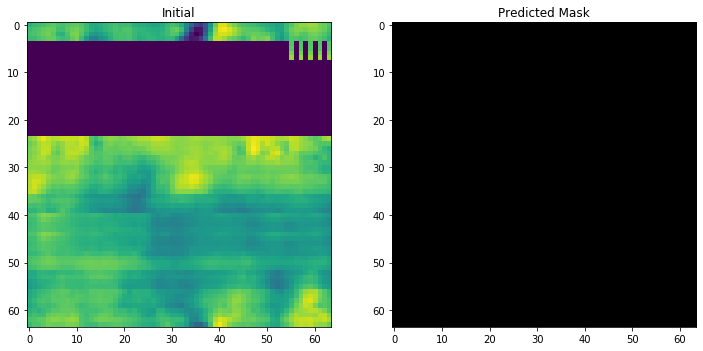

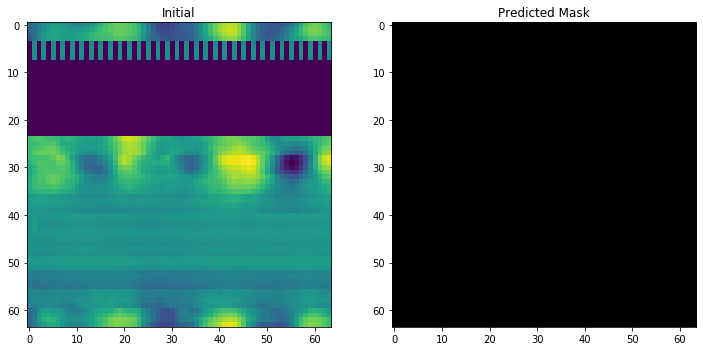

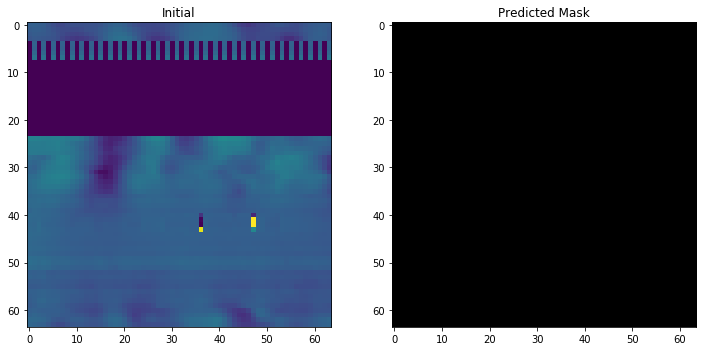

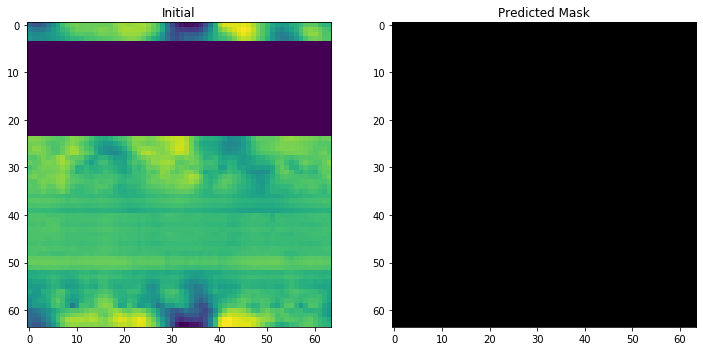

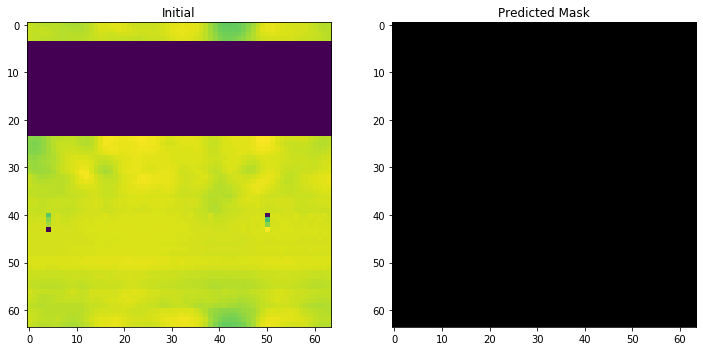

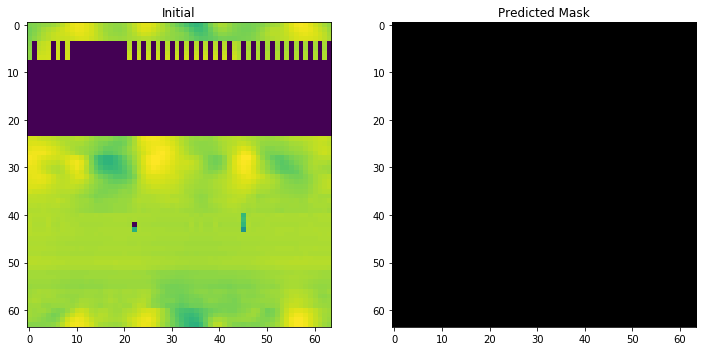

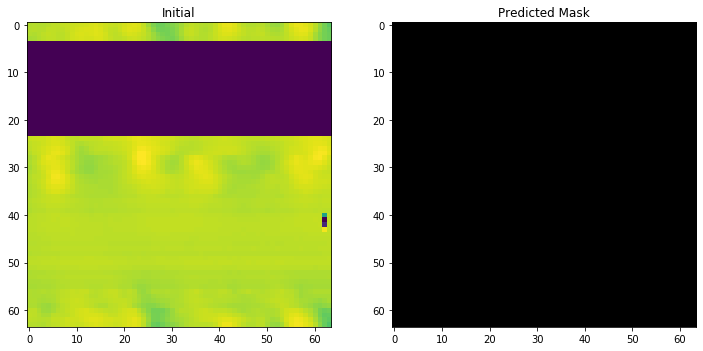

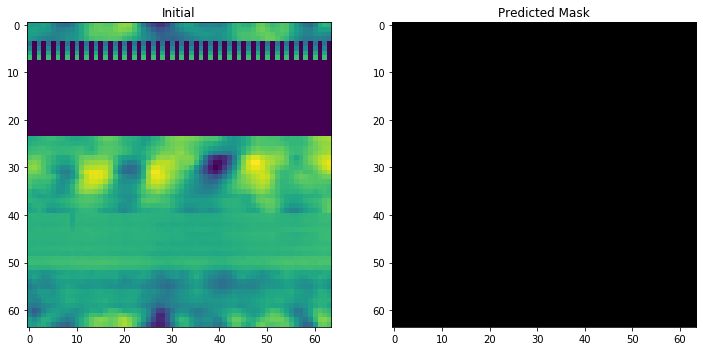

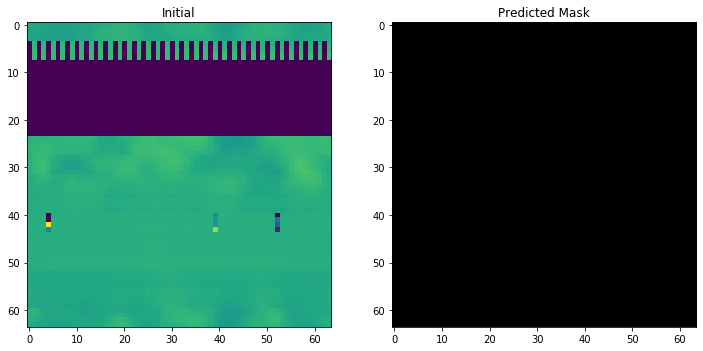

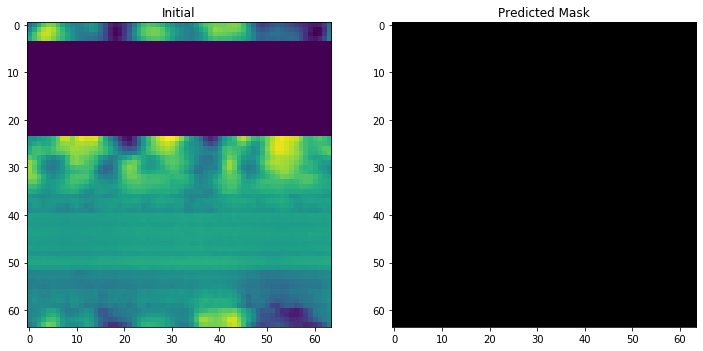

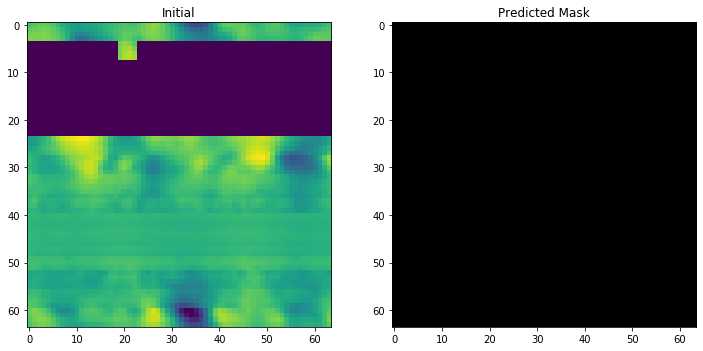

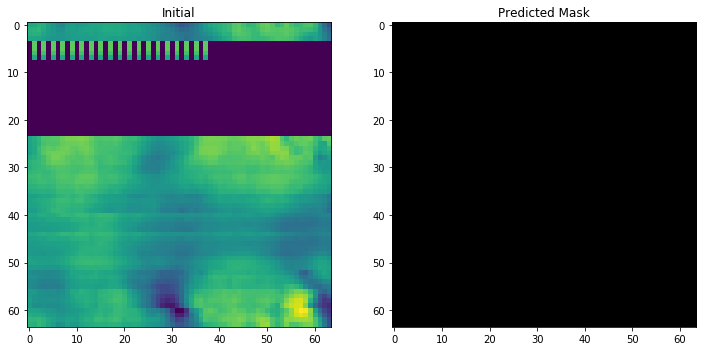

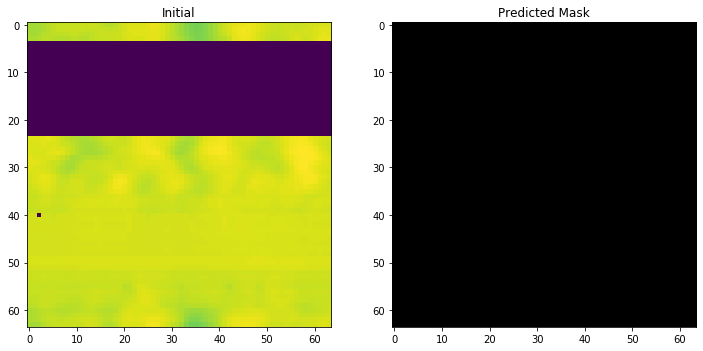

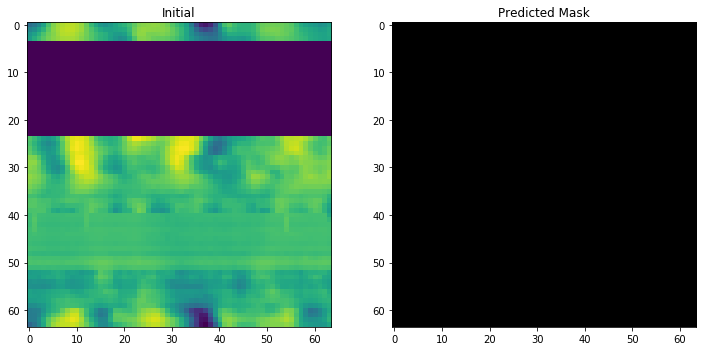

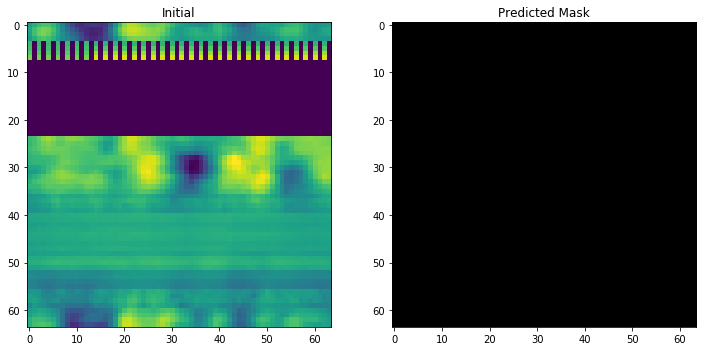

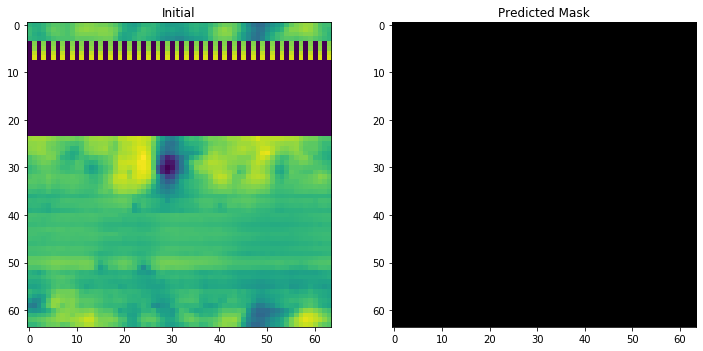

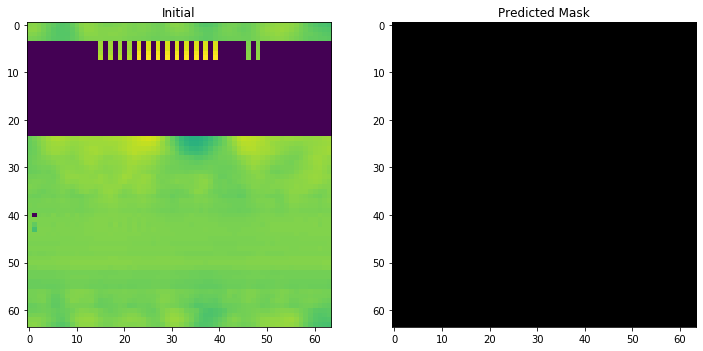

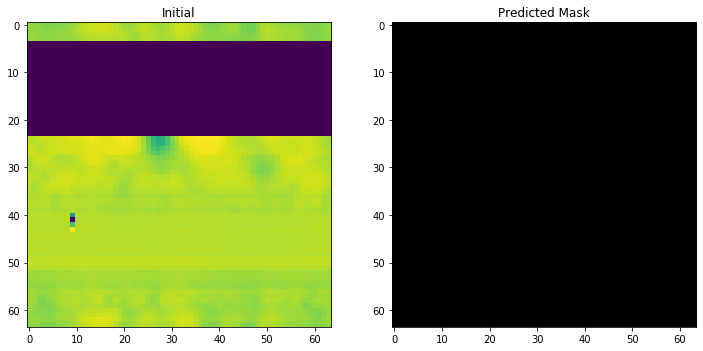

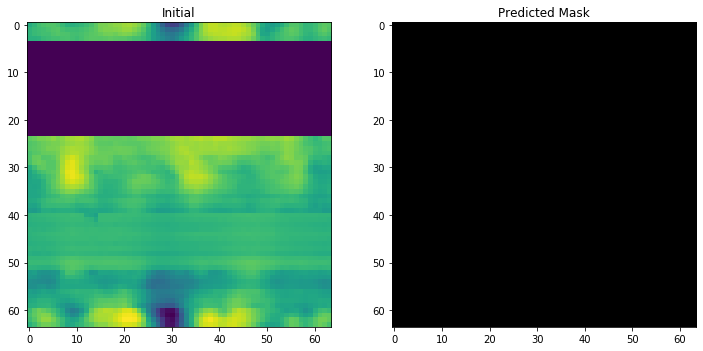

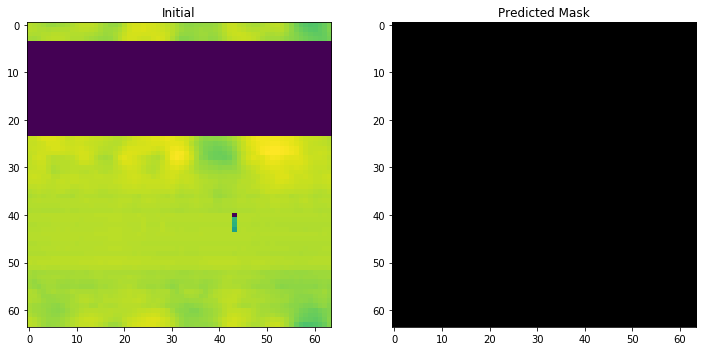

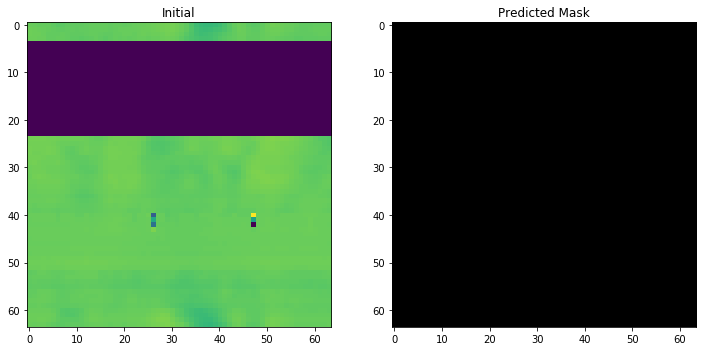

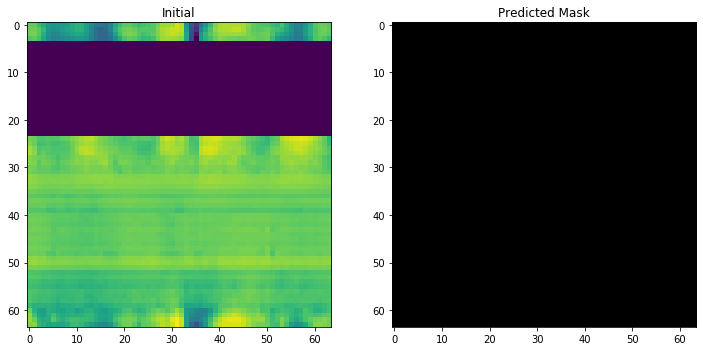

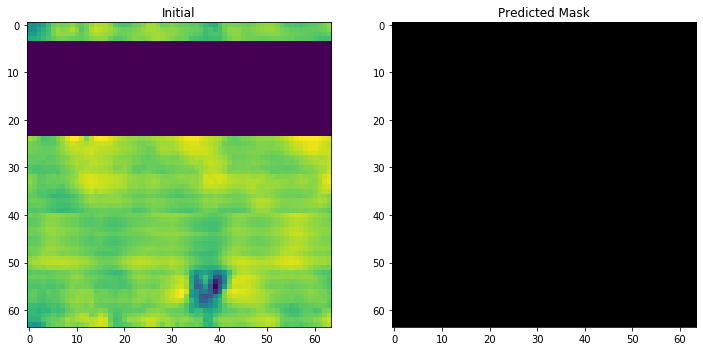

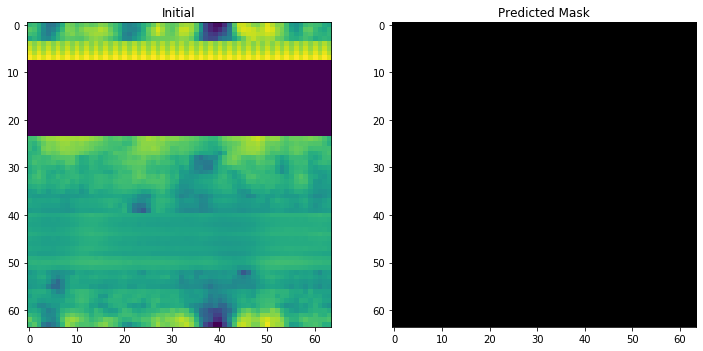

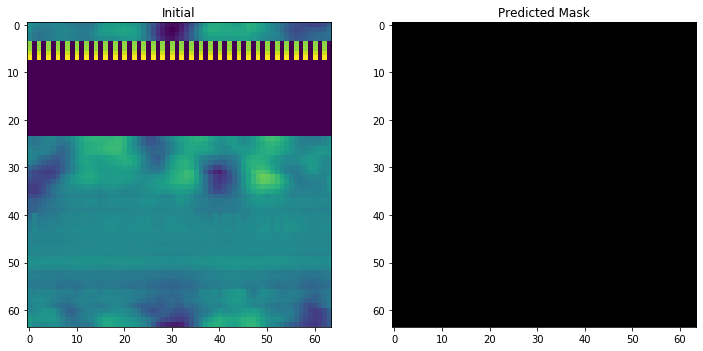

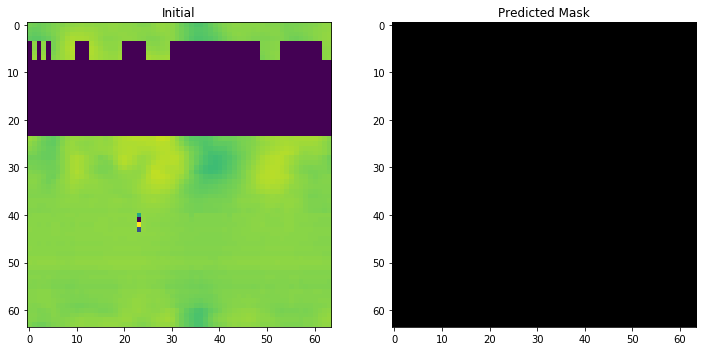

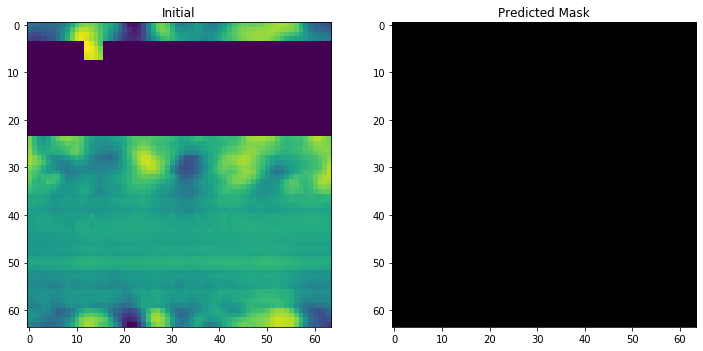

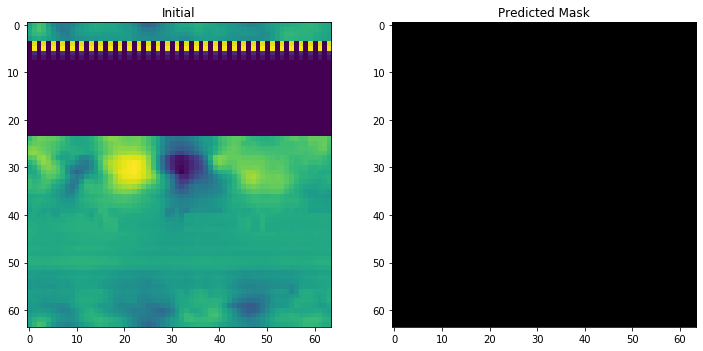

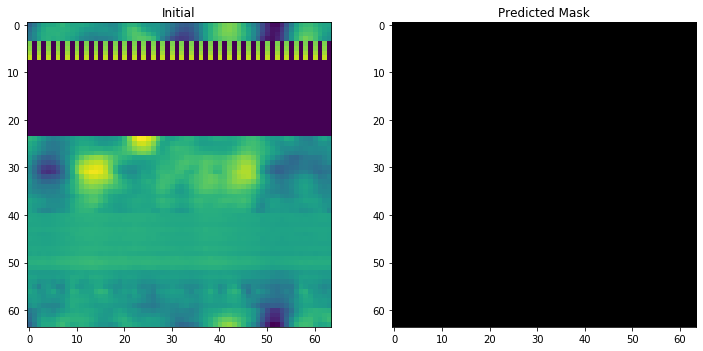

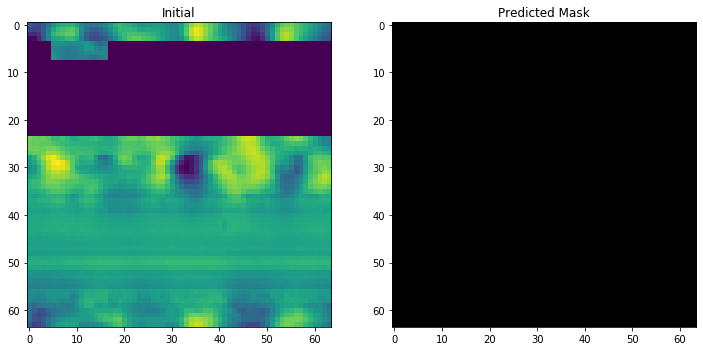

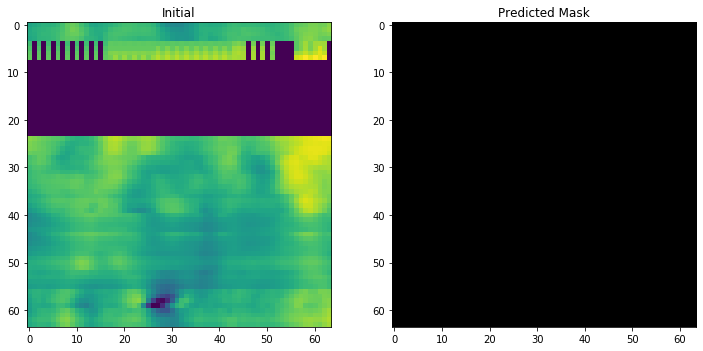

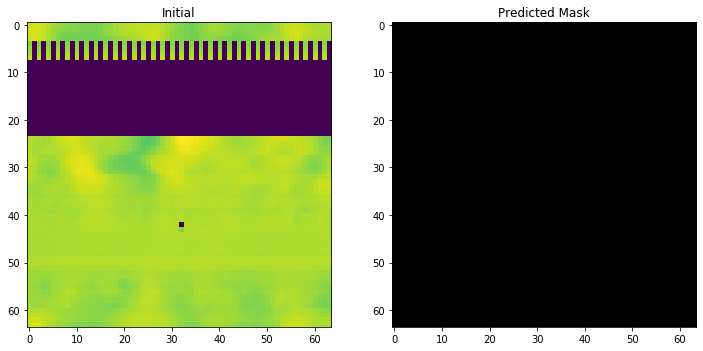

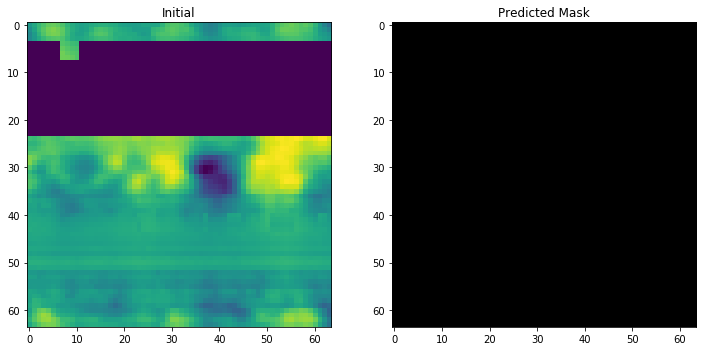

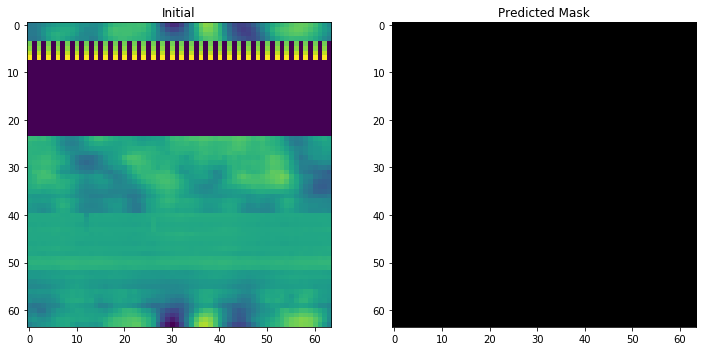

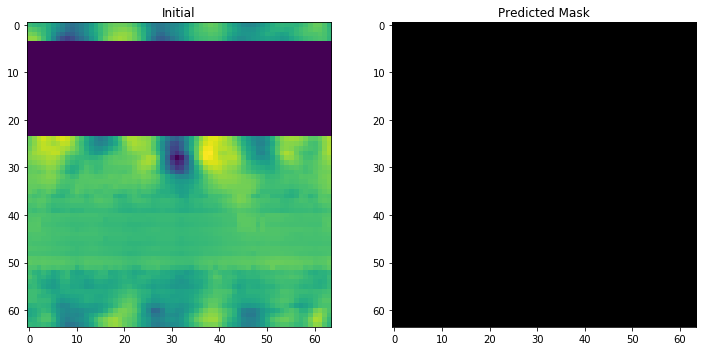

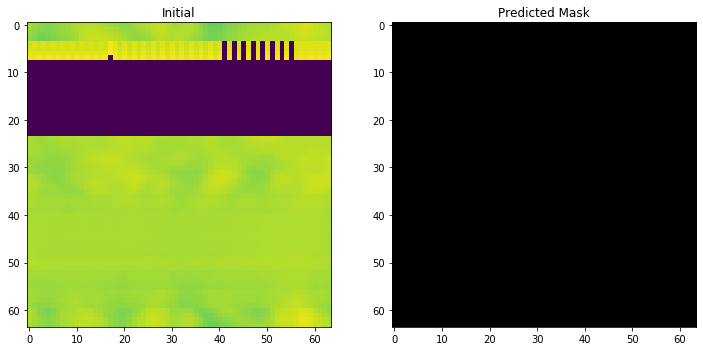

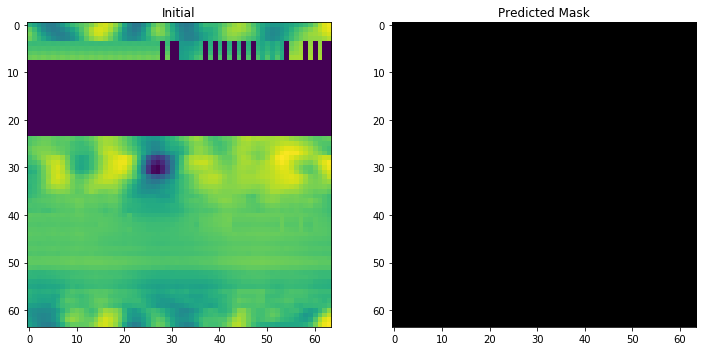

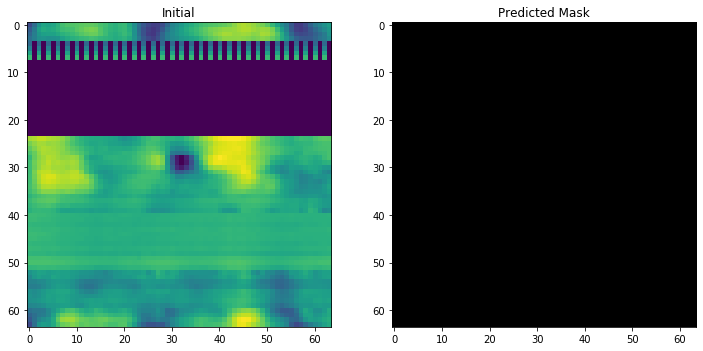

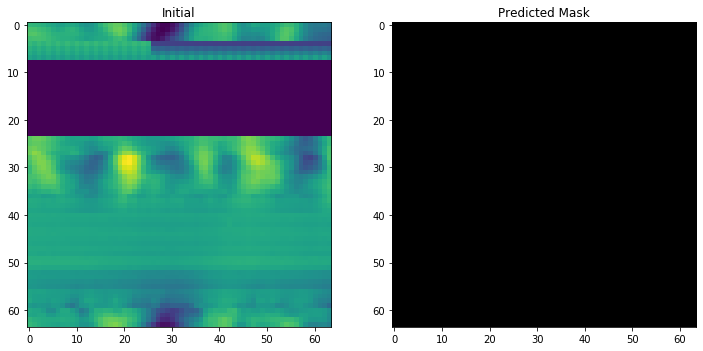

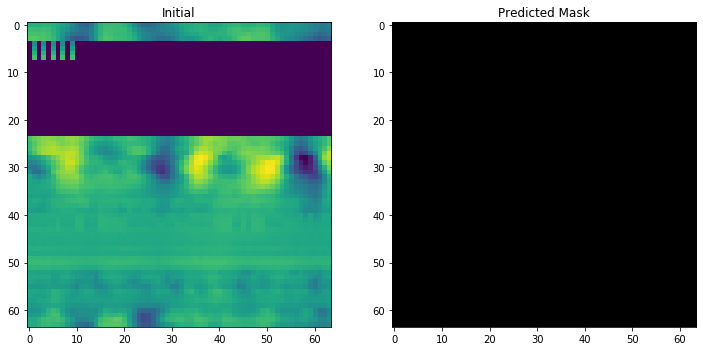

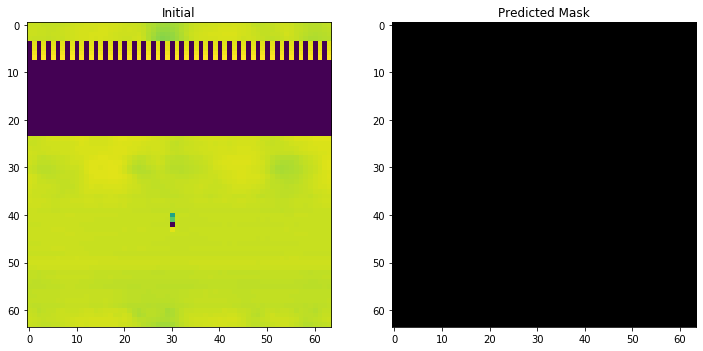

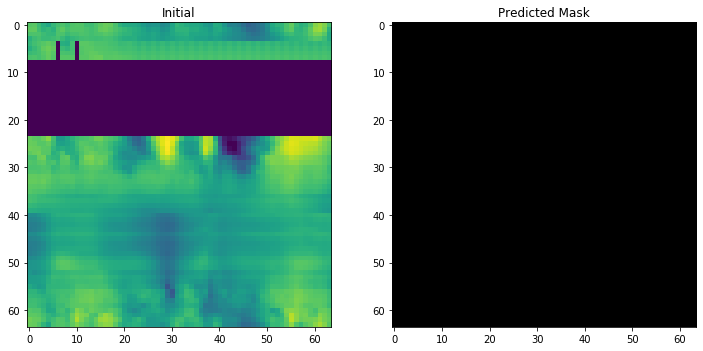

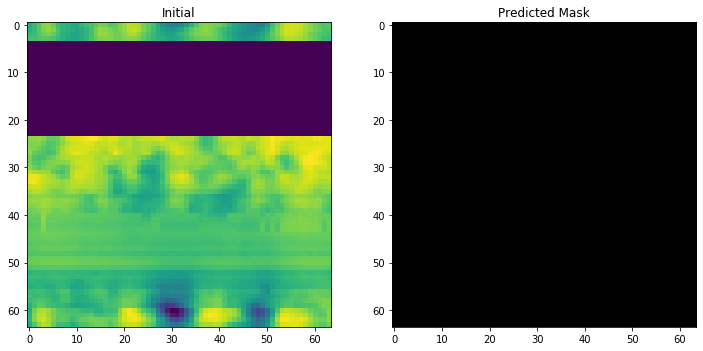

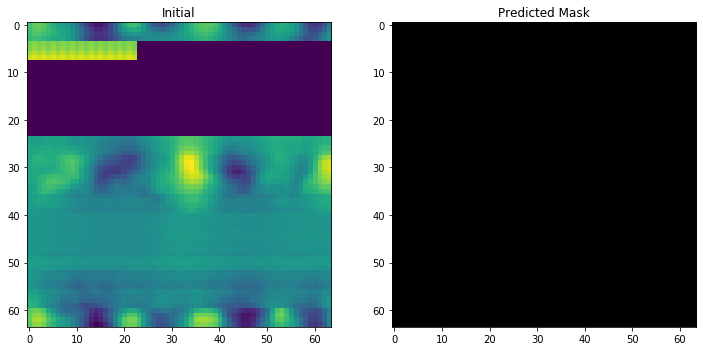

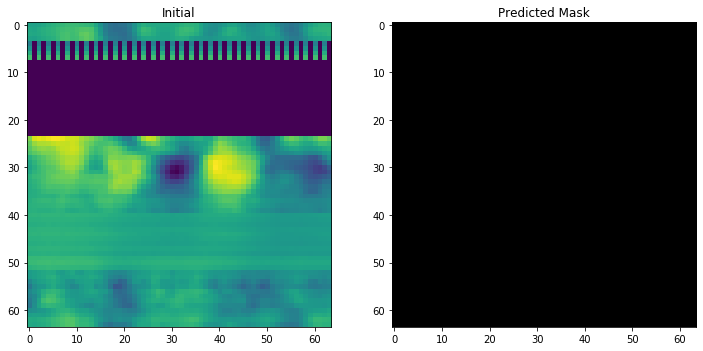

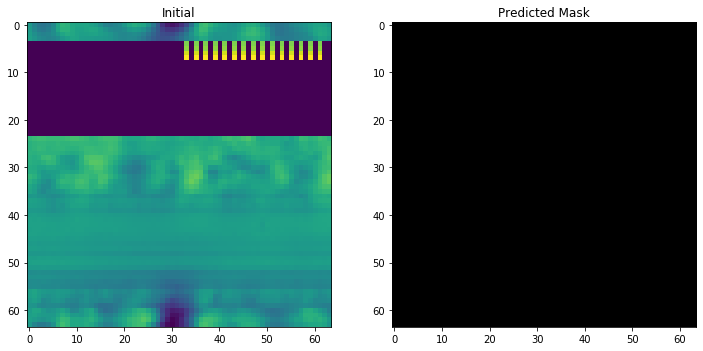

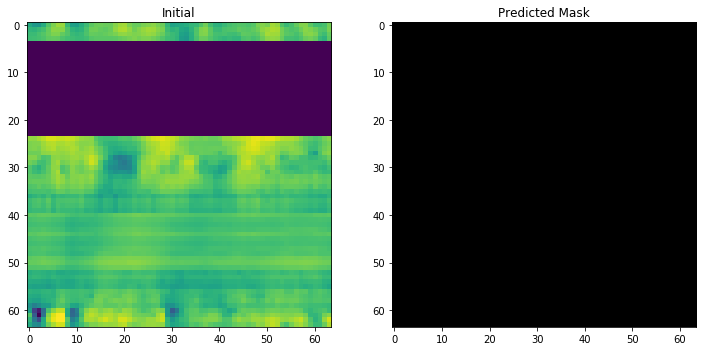

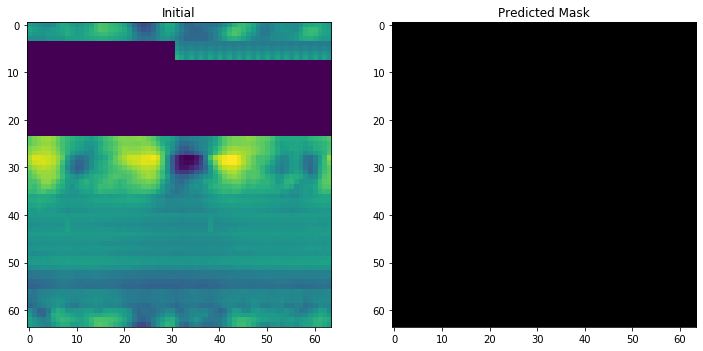

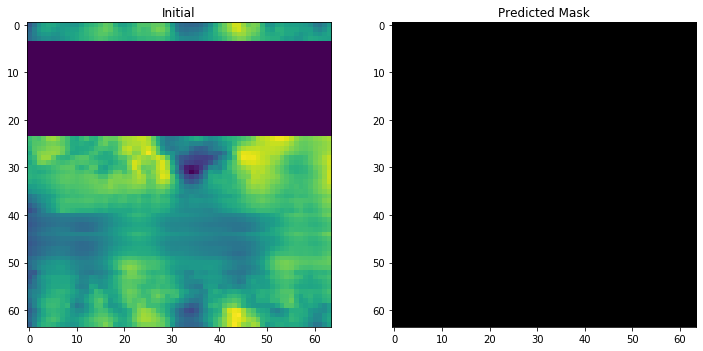

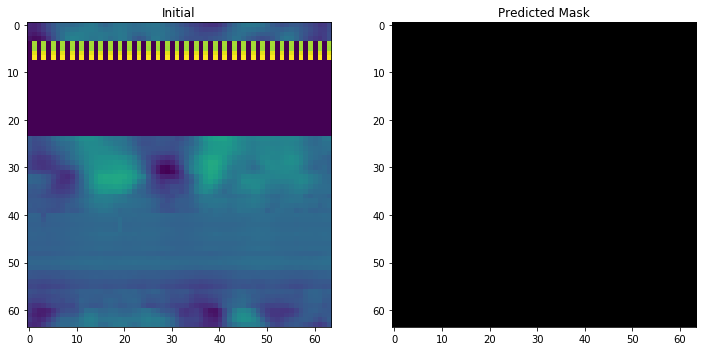

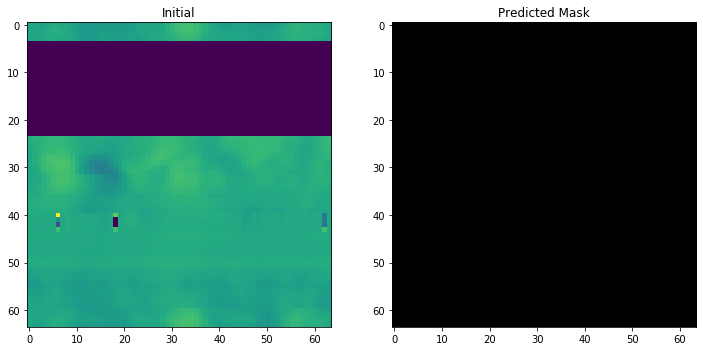

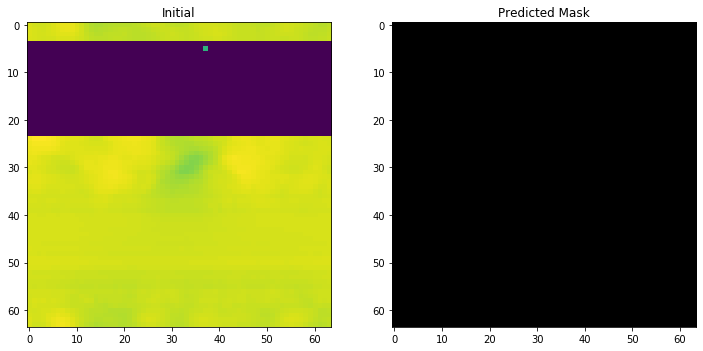

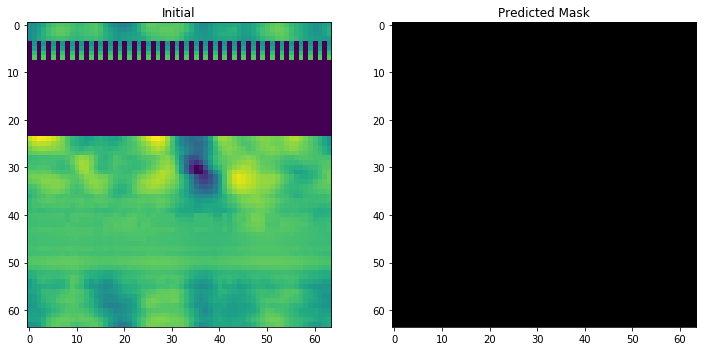

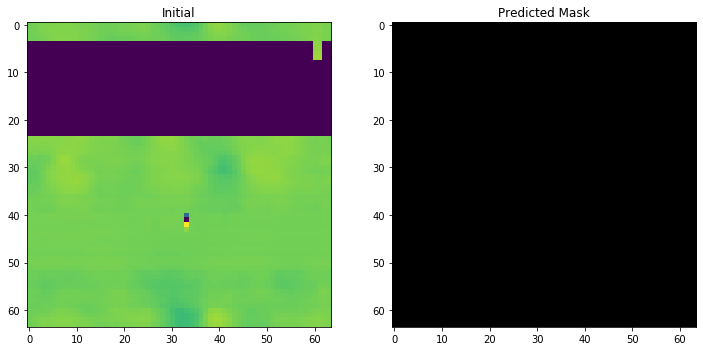

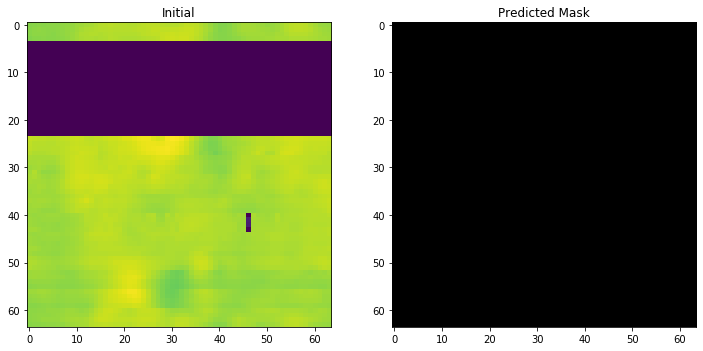

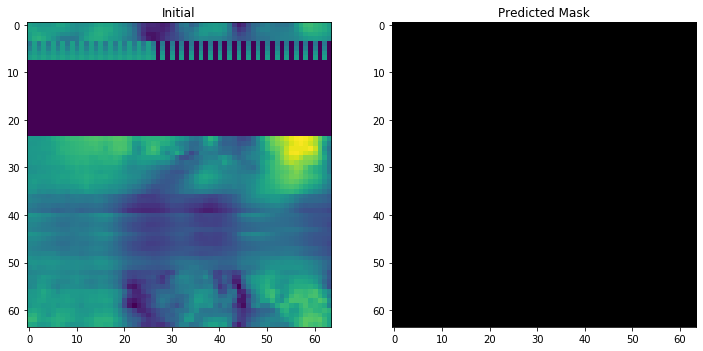

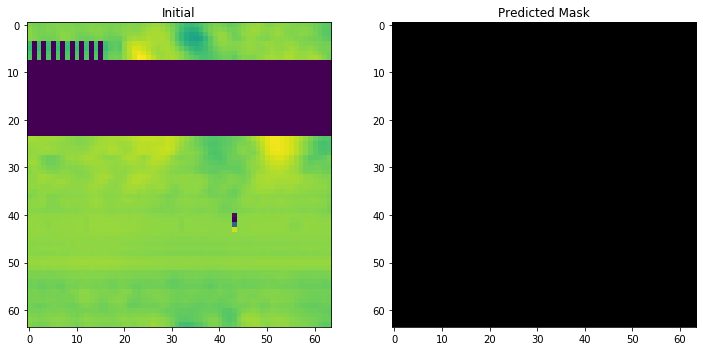

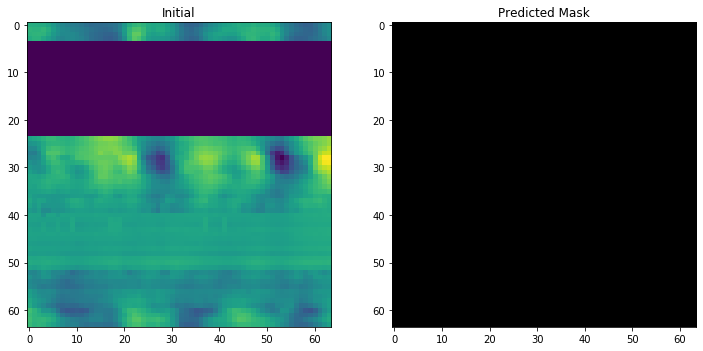

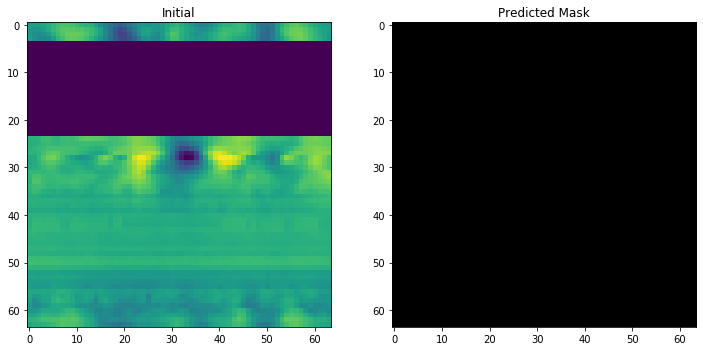

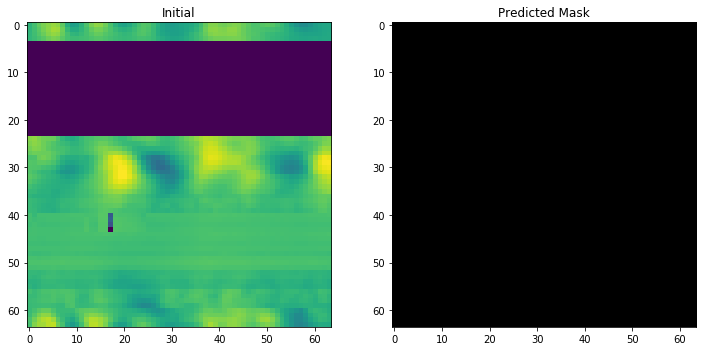

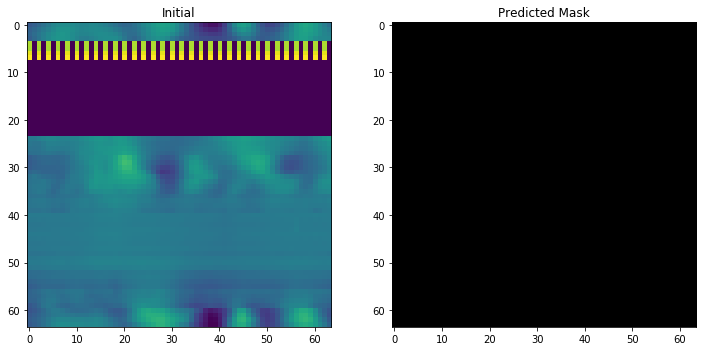

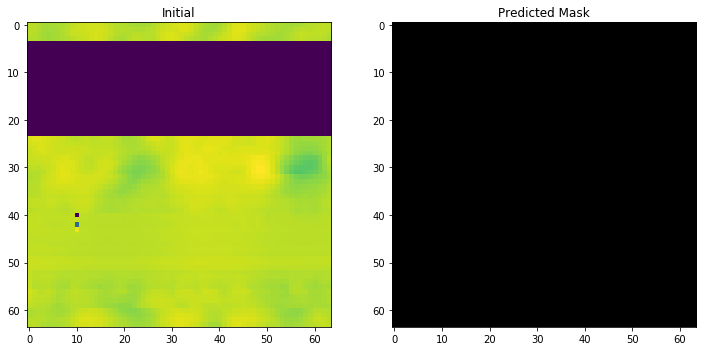

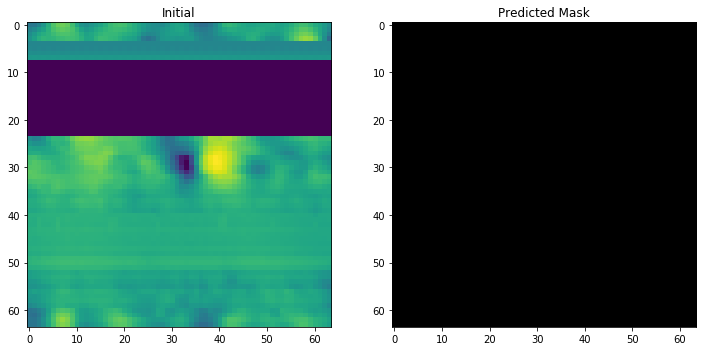

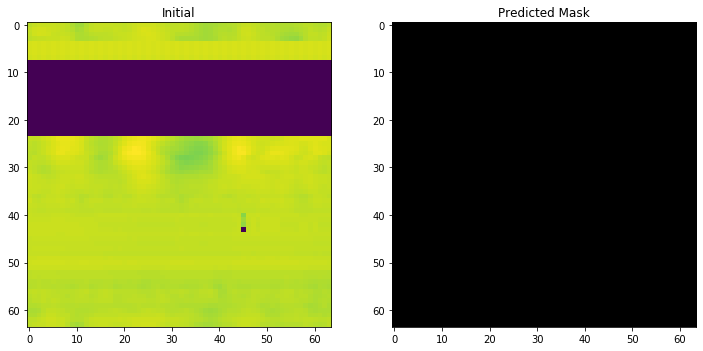

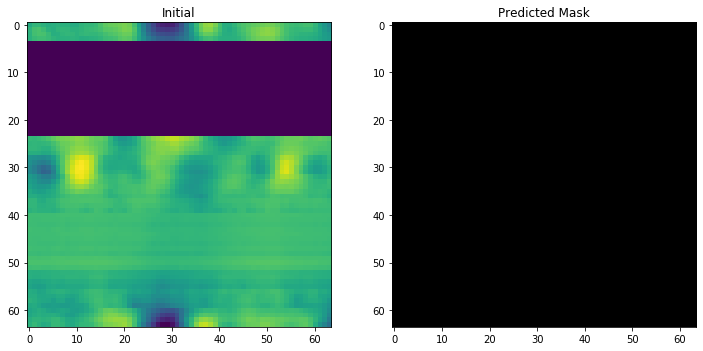

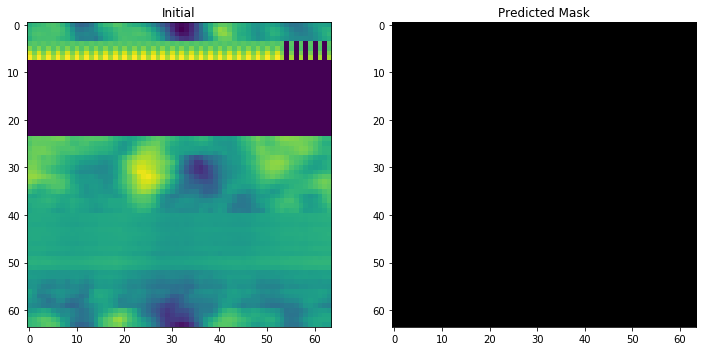

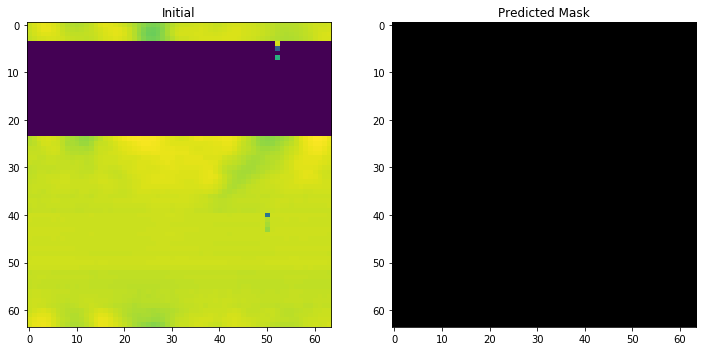

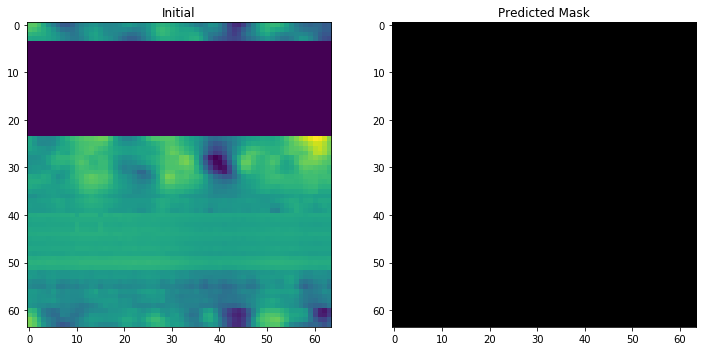

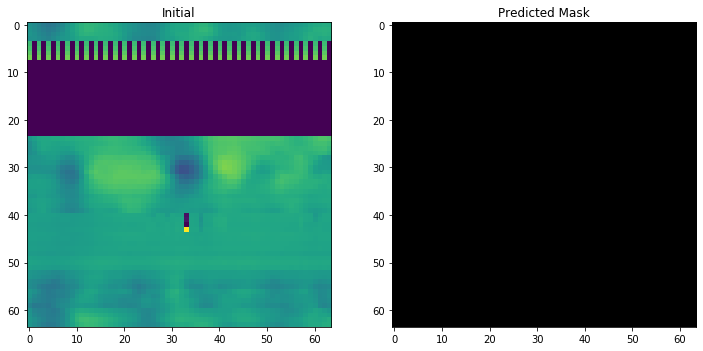

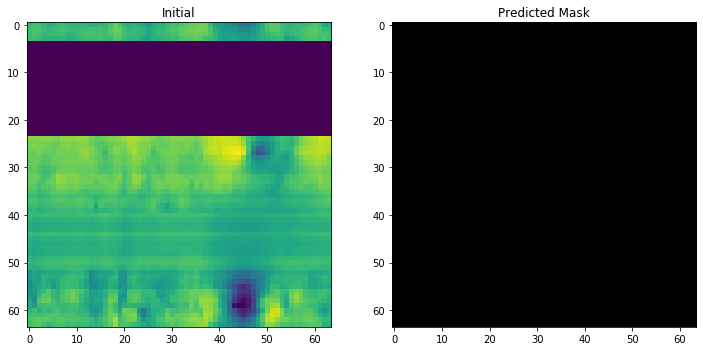

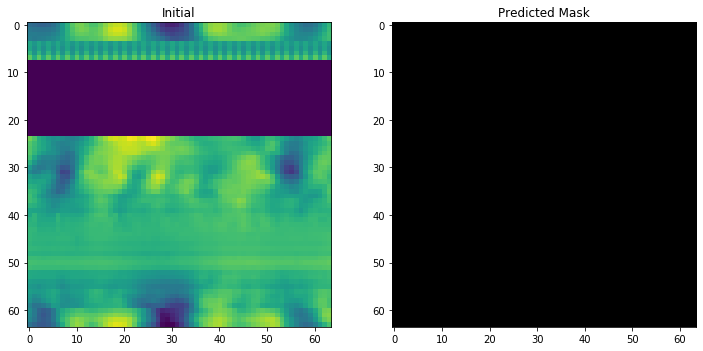

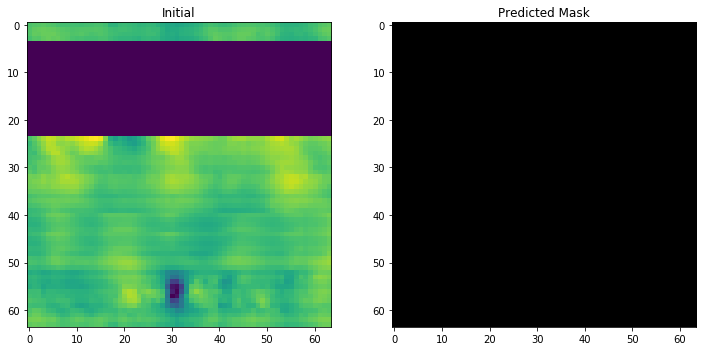

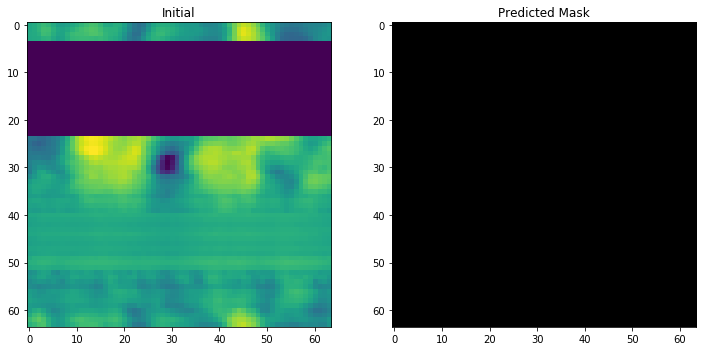

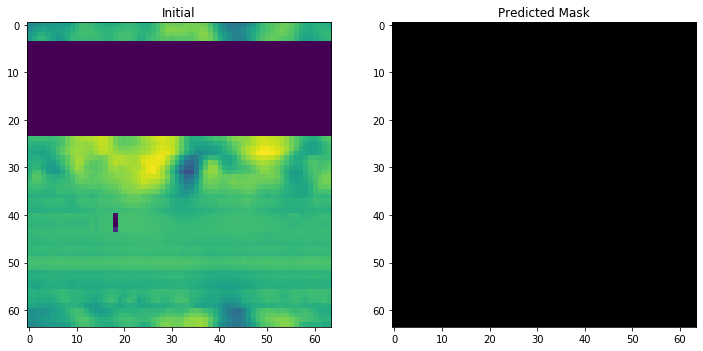

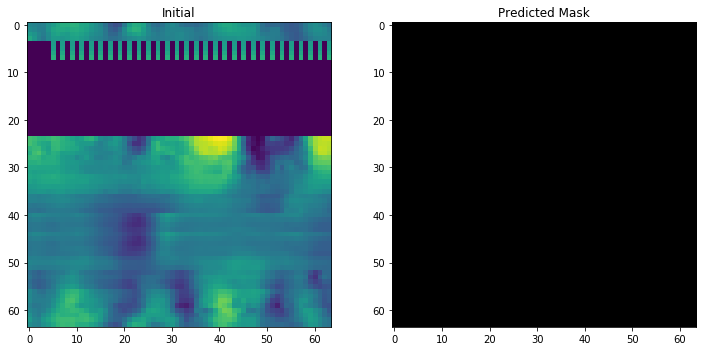

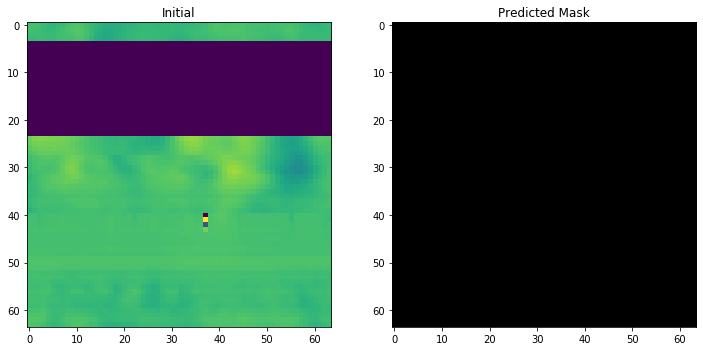

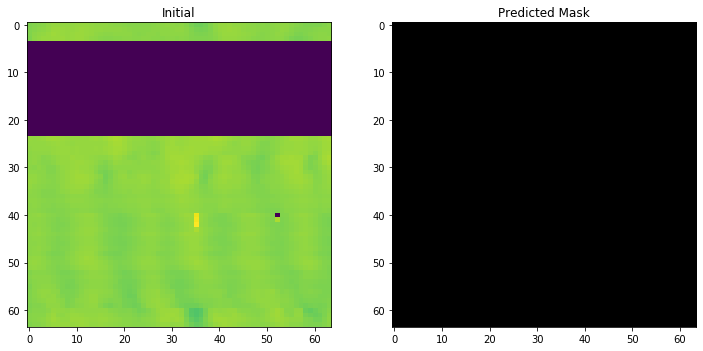

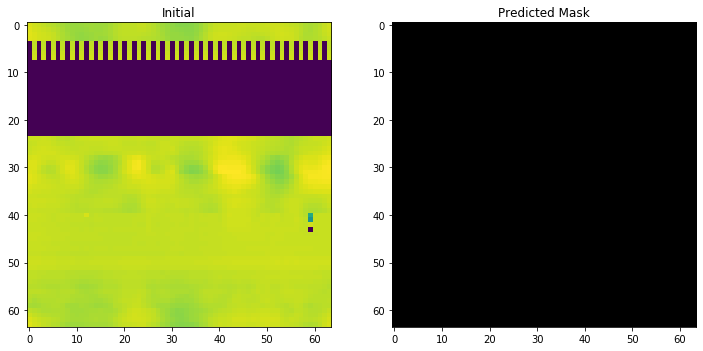

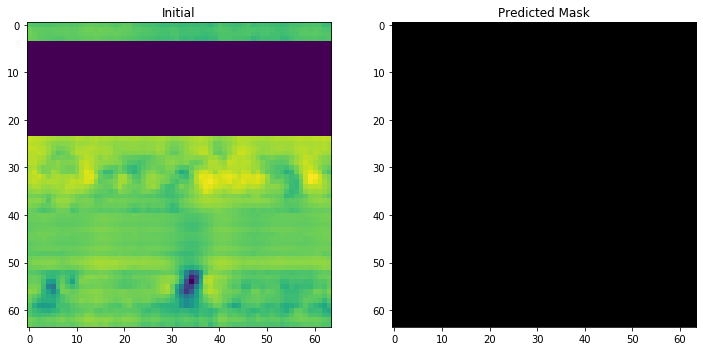

In [17]:
for i in range(len(Test_pred)):
  f = plt.figure(figsize=(12,7))
  # plt.subplots_adjust(wspace=0.2, hspace=1.3)
  ax1 = f.add_subplot(121)
  ax1.imshow(Images[i])
  ax1.set_title('Initial')

  ax2 = f.add_subplot(122)
  ax2.imshow(Test_pred[i],'gray')
  ax2.set_title('Predicted Mask')

In [18]:
part = inspector.values.T[:,idx:idx+64]

NameError: name 'idx' is not defined

In [ ]:
idx = 0
part = torch.tensor(inspector.values.T[:,idx:idx+64]).to(device).unsqueeze(0).unsqueeze(0).type(torch.float)
kk = model(part)

In [ ]:
kk.detach().cpu().numpy()[0][0][:563]

In [ ]:
idx = 0
new_pipe=[]
while idx < 245: #len(inspector):
    idx+=64
    part = inspector.values.T[:,idx-64:idx].astype(float)
    part[part==0.0]=np.nan
    skimage.io.imsave('buffer.png',part)
    part = skimage.io.imread('buffer.png')
    part[part==255]=254 
#     part = torch.tensor(part).to(device).unsqueeze(0).unsqueeze(0).type(torch.float) 
    
#     new_pipe.append(model(part).detach().cpu().numpy()[0][0])


In [ ]:
plt.imshow(part)
part = torch.tensor(part).to(device).unsqueeze(0).unsqueeze(0).type(torch.float) 
plt.figure()
plt.imshow(model(part).detach().cpu().numpy()[0][0])

In [ ]:
plt.imshow(new_pipe[0])